In [2]:
# ! pip install transformers
# ! pip install torchvision
# ! pip install wandb
# ! pip install datasets

In [1]:
import requests
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from datasets import load_dataset
import os
from io import BytesIO

In [2]:
output_directory = "images"

In [2]:
# Load the small-coco dataset
dataset = load_dataset("RIW/small-coco", split="train[:1000]")

# Specify the number of images you want to select
num_images_to_select = 50

# Calculate the step size to get equally spaced images
step_size = len(dataset) // num_images_to_select

# Specify the directory to save the images
os.makedirs(output_directory, exist_ok=True)

# Function to download and save images
def download_and_save_images(image_info, index):
    image_url = image_info['url']
    image_response = requests.get(image_url)

    # Check if the request was successful
    if image_response.status_code == 200:
        # Save the image to the specified directory
        image = Image.open(BytesIO(image_response.content))
        image_path = os.path.join(output_directory, f"{index + 1}.jpg")
        image.save(image_path)
        print(f"Image {index + 1} saved.")
    else:
        print(f"Failed to download image {index + 1}.")

# Download and save the selected images
j = 0
for i in range(0, len(dataset), step_size):
    image_info = dataset[i]
    download_and_save_images(image_info, j)
    j += 1

print("Images saved in the 'images' folder.")

Image 1 saved.
Image 2 saved.
Image 3 saved.
Image 4 saved.
Image 5 saved.
Image 6 saved.
Image 7 saved.
Image 8 saved.
Image 9 saved.
Image 10 saved.
Image 11 saved.
Image 12 saved.
Image 13 saved.
Image 14 saved.
Image 15 saved.
Image 16 saved.
Image 17 saved.
Image 18 saved.
Image 19 saved.
Image 20 saved.
Image 21 saved.
Image 22 saved.
Image 23 saved.
Image 24 saved.
Image 25 saved.
Image 26 saved.
Image 27 saved.
Image 28 saved.
Image 29 saved.
Image 30 saved.
Image 31 saved.
Image 32 saved.
Image 33 saved.
Image 34 saved.
Image 35 saved.
Image 36 saved.
Image 37 saved.
Image 38 saved.
Image 39 saved.
Image 40 saved.
Image 41 saved.
Image 42 saved.
Image 43 saved.
Image 44 saved.
Image 45 saved.
Image 46 saved.
Image 47 saved.
Image 48 saved.
Image 49 saved.
Image 50 saved.
Images saved in the 'images' folder.


In [10]:
import wandb
wandb.init(project="blip-2-adversaial-training", entity="capstone-project")

In [3]:
import torch
from transformers import AutoProcessor, Blip2ForConditionalGeneration
device = "cuda" if torch.cuda.is_available() else "cpu"


MODEL_ID = "Salesforce/blip2-opt-2.7b"
processor = AutoProcessor.from_pretrained(MODEL_ID)

In [4]:
# by default `from_pretrained` loads the weights in float32
# we load in float16 instead to save memory
# model = Blip2ForConditionalGeneration.from_pretrained(MODEL_ID, torch_dtype=torch.float16)
model = Blip2ForConditionalGeneration.from_pretrained(MODEL_ID)
model.to(device)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Blip2ForConditionalGeneration(
  (vision_model): Blip2VisionModel(
    (embeddings): Blip2VisionEmbeddings(
      (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (encoder): Blip2Encoder(
      (layers): ModuleList(
        (0-38): 39 x Blip2EncoderLayer(
          (self_attn): Blip2Attention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=1408, out_features=4224, bias=True)
            (projection): Linear(in_features=1408, out_features=1408, bias=True)
          )
          (layer_norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
          (mlp): Blip2MLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1408, out_features=6144, bias=True)
            (fc2): Linear(in_features=6144, out_features=1408, bias=True)
          )
          (layer_norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((

In [5]:
from transformers import BridgeTowerProcessor, BridgeTowerForMaskedLM

processor2 = BridgeTowerProcessor.from_pretrained("BridgeTower/bridgetower-large-itm-mlm")
model2 = BridgeTowerForMaskedLM.from_pretrained("BridgeTower/bridgetower-large-itm-mlm")
model2.to(device)

BridgeTowerForMaskedLM(
  (bridgetower): BridgeTowerModel(
    (cross_modal_text_transform): Linear(in_features=1024, out_features=1024, bias=True)
    (cross_modal_image_transform): Linear(in_features=1024, out_features=1024, bias=True)
    (token_type_embeddings): Embedding(2, 1024)
    (vision_model): BridgeTowerVisionModel(
      (visual): BridgeTowerVisionTransformer(
        (embeddings): BridgeTowerVisionEmbeddings(
          (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
          (position_embedding): Embedding(442, 1024)
        )
        (ln_pre): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (transformer): BridgeTowerTransformer(
          (resblocks): ModuleList(
            (0-23): 24 x BridgeTowerResidualAttention(
              (attn): MultiheadAttention(
                (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
              )
              (ln_1): LayerNorm((1024,

In [6]:
def get_input_optimizer(input_img, learning_rate):
    # this line to show that input is a parameter that requires a gradient
    # optimizer = torch.optim.Adam([input_img], lr=learning_rate)
    optimizer = torch.optim.Adam([input_img], lr=learning_rate)
    return optimizer

In [7]:
# We also put the model in evaluation mode, so that specific layers
# such as dropout or batch normalization layers behave correctly.
model.eval()
model.requires_grad_(False)

model2.eval()
model2.requires_grad_(False)

learning_rate = 0.01

# Text prompt
prompt = "Question: name one object in the image? Answer:"
target_word_index = 13599

text = "a <mask> looking out of the window"
target_word_index2 = 3428

In [8]:
delta = 1.0

In [ ]:
for i in range(1, 51):
    
    input_img = Image.open('images/' + str(i) + '.jpg').convert('RGB')
    input_img = torch.tensor(np.array(input_img) / 255.0)
    
    inputs = processor(input_img, text=prompt, return_tensors="pt").to(device)
    inputs2 = processor2(input_img, text, return_tensors="pt").to(device)
    inputs['pixel_values'].requires_grad_(False)
    inputs2['pixel_values'].requires_grad_(False)
    change = torch.zeros_like(inputs2['pixel_values']).to(device)
    change.requires_grad = True
    optimizer = get_input_optimizer(change, learning_rate)
    deep_copy_tensor = inputs['pixel_values'].clone()
    deep_copy_tensor2 = inputs2['pixel_values'].clone()

    losses = []
    torch.autograd.set_detect_anomaly(True)
    

    print('Optimizing..')
    run = [0]
    losses = []
    while True:

        inputs['pixel_values'] = deep_copy_tensor + change[:,:,:224,:224]
        inputs2['pixel_values'] = deep_copy_tensor2 + change

        optimizer.zero_grad()

        outputs = model(**inputs)
        outputs2 = model2(**inputs2)

        # Apply softmax to the logits
        logits = outputs.logits[0, 1:2, :]
        logits2 = outputs2.logits[0, 2:3, :]

        probabilities = torch.softmax(logits, dim=1)
        probabilities2 = torch.softmax(logits2, dim=1)

        target_prob = probabilities[0, target_word_index]
        target_prob2 = probabilities2[0, target_word_index2]

        loss = -torch.log(target_prob)
        loss += -torch.log(target_prob2)

        print('loss', loss)

        losses.append(loss.item())

        if loss.item()<0.1:
            optimized_image = inputs['pixel_values'].detach().cpu().numpy()

            # Scale each channel independently between 0 and 1
            min_vals = optimized_image.min(axis=(2, 3), keepdims=True)
            max_vals = optimized_image.max(axis=(2, 3), keepdims=True)
            scaled_image = (optimized_image - min_vals) / (max_vals - min_vals)

            image_filename = f"adversary_{i}.jpg"
            image_path = os.path.join(output_directory, image_filename)

            # Convert the scaled image to uint8 for saving
            scaled_image_uint8 = (scaled_image * 255).astype(np.uint8)

            # Save the image using PIL
            Image.fromarray(np.transpose(scaled_image_uint8[0, :, :, :], (1, 2, 0)), mode="RGB").save(image_path)
            
            break

        loss.backward()

        run[0] += 1

        optimizer.step()

        with torch.no_grad():
            change[:] = change.clamp(-delta, delta)

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


Optimizing..
loss tensor(21.7160, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(22.2284, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(21.4531, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(21.2170, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(19.6325, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(18.0374, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(16.0140, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(14.7075, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(13.9173, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(13.8896, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(13.9028, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(13.9284, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(13.9040, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(13.9126, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(13.9169, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(13.8850, device='cuda:0', grad_fn=<AddBackwar

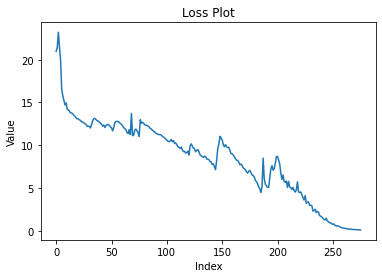

In [26]:
losses_array = [loss.detach().cpu().numpy() for loss in losses]

# Plot the array
plt.plot(np.array(losses_array))

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Loss Plot')

# Show the plot
plt.show()

In [66]:
outputs = model(**inputs)
logits = outputs.logits[0, 1:2, :]
# print('is logits nan', torch.isnan(logits).any())
# print(logits.size())
probabilities = torch.softmax(logits, dim=1)

# Assuming target_word_index is a scalar
target_prob = probabilities[0, target_word_index]

print(target_prob)

tensor(0.9075, device='cuda:0', grad_fn=<SelectBackward0>)


In [38]:
torch.argmax(probabilities, dim=1)

tensor([13599], device='cuda:0')

In [39]:
inputs['pixel_values'] = deep_copy_tensor + change

In [40]:
outputs = model.generate(**inputs)
print(processor.decode(outputs[0], skip_special_tokens=True))

/n/home09/nnayak/.local/lib/python3.8/site-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


 the black object in the image



In [41]:
processor.batch_decode(torch.tensor([13599]), skip_special_tokens=True)

['chair']